In [2]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Run once
#!pip install --no-cache -U pystan==2.19.1.1 prophet

In [24]:
import os
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
import investpy
from datetime import date, datetime
from pathlib import Path
from dateutil.relativedelta import relativedelta
from dataclasses import dataclass, field
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

In [6]:
%matplotlib inline
pd.set_option('display.max_rows', 500)

In [7]:
COUNTRY = "malaysia"                   
DATASET_FOLDER = "test_data"
TARGET_DATASET_FOLDER = f"{DATASET_FOLDER}/{COUNTRY}"
STOCKS_DATASET = f"{TARGET_DATASET_FOLDER}/stocks.csv"
STOCKS_INFO_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_info.csv"
STOCKS_FINANCE_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_finance.csv"
STOCKS_DIVIDENDS_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_dividends.csv"
STOCKS_SELECTED = f"{TARGET_DATASET_FOLDER}/stocks_selected.csv"
STOCKS_HISTORICAL_PRICES = f"{TARGET_DATASET_FOLDER}/stocks_historcal_prices.csv"

FROM_DATE = '1/1/2017'
TO_DATE = datetime.strftime(date.today(), '%d/%m/%Y')

In [8]:
def save_csv(df, file_name, index=True):
    df.to_csv(file_name, header=True, index=index)

In [9]:
df_stocks_selected = pd.read_csv(STOCKS_SELECTED)

In [10]:
def get_stock_historical_prices(symbol, country):
    try:
        return investpy.get_stock_historical_data(symbol, country, FROM_DATE, TO_DATE)
    except:
        return None
    
def download_historical_prices(df):
    df_history = None
    count = 0
    for _, row in df.iterrows():
            count = count + 1
            print(f"{count}/{len(df)}: {row.Symbol}")
            df_stock = get_stock_historical_prices(row.Symbol, COUNTRY)
            if df_stock is None:
                continue
            df_stock['Symbol'] = row.Symbol
            if df_history is None:
                df_history  = df_stock
            else:
                df_history = df_history.append(df_stock)
            if count % 10 == 0:
                save_csv(df_history, STOCKS_HISTORICAL_PRICES)
                time.sleep(3)
    save_csv(df_history, STOCKS_HISTORICAL_PRICES)

In [11]:
# download_historical_prices(df_stocks_selected)

## Forecast Changes

In [12]:
df_history = pd.read_csv(STOCKS_HISTORICAL_PRICES, parse_dates=['Date'])
df_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34656 entries, 0 to 34655
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      34656 non-null  datetime64[ns]
 1   Open      34656 non-null  float64       
 2   High      34656 non-null  float64       
 3   Low       34656 non-null  float64       
 4   Close     34656 non-null  float64       
 5   Volume    34656 non-null  int64         
 6   Currency  34656 non-null  object        
 7   Symbol    34656 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 2.1+ MB


<AxesSubplot:>

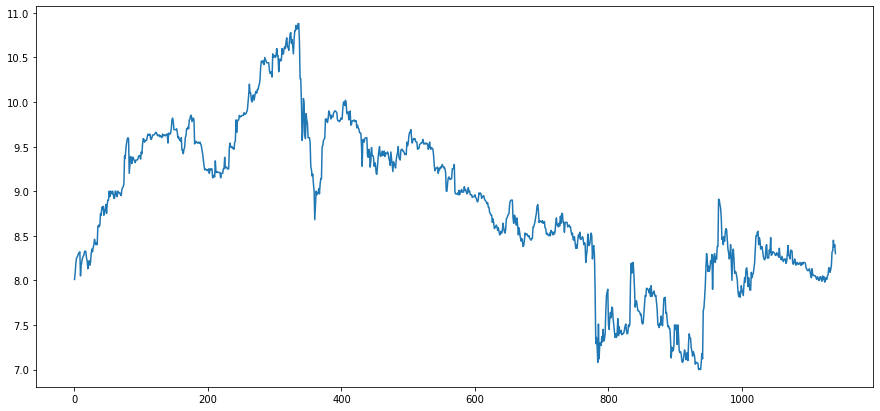

In [13]:
# Try with 1 stock
df_stock = df_history[df_history['Symbol'] == 'MBBM'].copy()
df_stock['Close'].plot(figsize = (15,7))

In [52]:
# Features to test
INTERVAL = 5

df_analysis = df_stock[['Date', 'Close']]
display(df_analysis.head(10))
df_interval_min = df_analysis['Close'].groupby(df_analysis.index // INTERVAL).min()
df_interval_max = df_analysis['Close'].groupby(df_analysis.index // INTERVAL).max()

display(df_interval_min.head(10))


,Date,Close
0,2017-01-03,8.01
1,2017-01-04,8.08
2,2017-01-05,8.19
3,2017-01-06,8.25
4,2017-01-09,8.26
5,2017-01-10,8.28
6,2017-01-11,8.30
7,2017-01-12,8.31
8,2017-01-13,8.32
9,2017-01-16,8.05


0    8.01
1    8.05
2    8.17
3    8.22
4    8.13
5    8.30
6    8.40
7    8.60
8    8.73
9    8.75
Name: Close, dtype: float64

/home/alpha2phi/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Initial log joint probability = -20.385
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      43       1309.36   0.000344364       59.7514   6.441e-06       0.001      104  LS failed, Hessian reset 
      99       1309.44   7.66809e-06        50.817      0.6917      0.6917      191   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158        1309.6   9.67849e-05       36.8023   1.751e-06       0.001      309  LS failed, Hessian reset 
     199       1309.61   1.61512e-05       44.4334           1           1      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       1309.62   1.48308e-05       50.9513     2.4e-07       0.001      425  LS failed, Hessian reset 
     299       1309.64   0.000355373       36.7041      0.4257           1      556   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

'MAE: 0.018'

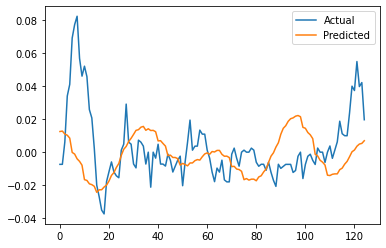

In [30]:
TEST_DATE = '2021-03-01'
END_DATE = '2021-09-01'

# Change names to fit prophet
df_analysis.rename(columns={'Date': 'ds', 'Pct_Change': 'y'}, inplace=True)

# Create train and test sets
df_train = df_analysis[df_analysis['ds'] < TEST_DATE]
df_test = df_analysis[df_analysis['ds'] >= TEST_DATE]

# Fit the training set
model = Prophet(daily_seasonality=)
model.fit(df_train)

# Predict
df_predict = df_test.drop(columns=['y'])
preds = model.predict(df_predict)

# Evaluate
y_true = df_test['y'].values
y_pred = preds['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
display('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()